In [1]:
import numpy as np
import pandas as pd
import torch

import logging
from tqdm import tqdm
import math
import argparse
import os

 #  Load Pretrained model
 Load Pretrained GPT2 model from transformers module

In [2]:
!git clone https://github.com/huggingface/transformers
!pip install transformers/
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers.optimization import AdamW, get_linear_schedule_with_warmup

Cloning into 'transformers'...
remote: Enumerating objects: 141318, done.
remote: Counting objects: 100% (1328/1328), done.
remote: Compressing objects: 100% (628/628), done.
remote: Total 141318 (delta 793), reused 1029 (delta 575), pack-reused 139990
Receiving objects: 100% (141318/141318), 139.45 MiB | 17.19 MiB/s, done.
Resolving deltas: 100% (105780/105780), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.5 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.30.0.dev0-py3-none-any.whl size=7108038 sha256=2ad636280549e8d16fd0a26c063dd2cf7216911c8e84f02cce5a5840fca8eb61
  Stored in directory: /tmp/pip-ephem

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=88888)
parser.add_argument("--model_name", default="gpt2", type=str)
parser.add_argument("--max_seq_length", default=512, type=int)
parser.add_argument("--train_batch_size", default=8, type=int)
parser.add_argument("--valid_batch_size", default=8, type=int)
parser.add_argument("--num_train_epochs", default=3, type=int)
parser.add_argument("--warmup", default=0.1, type=float)
parser.add_argument("--learning_rate", default=0.001, type=float)
parser.add_argument("--input_text_path", default='../input/story-text', type=str)
args, _ = parser.parse_known_args()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the Data

In [5]:
import pickle
DATAPATH= "/content/drive/MyDrive/Colab Notebooks/DL Final Project/Pickles-finalpartition/"

def combinetext(prompt, story):
    with open(DATAPATH+prompt, 'rb') as f:
        prompts = pickle.load(f)

    with open(DATAPATH+story, 'rb') as f:
        stories = pickle.load(f)
    assert len(prompts)==len(stories)
    combine=[]
    for i in range(len(prompts)):
        combine.append(' '.join(prompts[i])+' <sep> '+" ".join(stories[i][:300]))
    return combine

def cleanpunctuation(s):
    for p in '!,.:;?':
        s=s.replace(' '+p,p)
    s=s.replace(' '+'n\'t','n\'t')
    s=s.replace(' '+'\'s','\'s')
    s=s.replace(' '+'\'re','\'re')
    s=s.replace(' '+'\'ve','\'ve')
    s=s.replace(' '+'\'ll','\'ll')
    s=s.replace(' '+'\'am','\'am')
    s=s.replace(' '+'\'m','\'m')
    s=s.replace(' '+'\' m','\'m')
    s=s.replace(' '+'\'m','\'m')
    s=s.replace(' '+'\' ve','\'ve')
    s=s.replace(' '+'\' s','\'s')
    s=s.replace('<newline>','\n')
    return s   

train_text=combinetext('train_src_tokenized.pickle', 'train_tgt_tokenized.pickle')
train_text=list(map(cleanpunctuation,train_text))
valid_text=combinetext('val_src_tokenized.pickle', 'val_tgt_tokenized.pickle')
valid_text=list(map(cleanpunctuation,valid_text))
test_text=combinetext('test_src_tokenized.pickle', 'test_tgt_tokenized.pickle')
test_text=list(map(cleanpunctuation,test_text))


In [6]:
print(len(train_text))
print(len(valid_text))
print(len(test_text))

10000
2500
2500


# Preprocess the data

In [7]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token=tokenizer.eos_token

inputs_train = tokenizer(train_text, padding=True,truncation=True,max_length=args.max_seq_length)
inputs_valid=tokenizer(valid_text, padding=True,truncation=True,max_length=args.max_seq_length)
inputs_test = tokenizer(test_text, padding=True,truncation=True,max_length=args.max_seq_length)

In [8]:
def create_labels(inputs):
    labels=[]
    for ids,attention_mask in zip(inputs['input_ids'],inputs['attention_mask']):
        label=ids.copy()
        real_len=sum(attention_mask)
        padding_len=len(attention_mask)-sum(attention_mask)
        label[:]=label[:real_len]+[-100]*padding_len
        labels.append(label)
    inputs['labels']=labels
    
create_labels(inputs_train)
create_labels(inputs_valid)
create_labels(inputs_test)

In [9]:
class StoryDataset:
    def __init__(self, inputs):
        self.ids = inputs['input_ids']
        self.attention_mask = inputs['attention_mask']
        self.labels=inputs['labels']

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, item):

        return [torch.tensor(self.ids[item], dtype=torch.long),
                torch.tensor(self.attention_mask[item], dtype=torch.long),
                torch.tensor(self.labels[item], dtype=torch.long)]
            

In [10]:
train_batch_size=args.train_batch_size
valid_batch_size=args.valid_batch_size
traindata=StoryDataset(inputs_train)
train_dataloader = torch.utils.data.DataLoader(
    traindata,
    shuffle=False,
    batch_size=train_batch_size)

validdata=StoryDataset(inputs_valid)
valid_dataloader = torch.utils.data.DataLoader(
    validdata,
    shuffle=False,
    batch_size=valid_batch_size)

testdata=StoryDataset(inputs_test)
test_dataloader = torch.utils.data.DataLoader(
    testdata,
    shuffle=False,
    batch_size=valid_batch_size)

# Load GPT-2

In [11]:
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Evaluation Metrics

In [12]:
def generate_story(prompt,k=None,p=0.9,output_length=300,temperature=1,num_return_sequences=1,repetition_penalty=1.0):
    encoded_prompt = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt").to('cuda')
    model.to('cuda')
    model.eval()
    generated_story = ""
    
    output_sequences = model.generate(
        input_ids=encoded_prompt,
        max_length=output_length,
        temperature=temperature,
        top_k=None,
        top_p=p,
        repetition_penalty=repetition_penalty,
        do_sample=True,
        num_return_sequences=num_return_sequences
    )
    
    if len(output_sequences.shape) > 2:
        output_sequences.squeeze_()
    for generated_sequence_idx, generated_sequence in enumerate(output_sequences):
        generated_sequence = generated_sequence.tolist()
        text = tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True)
        text = text[: text.find(tokenizer.eos_token)]
        generated_story+= text
    return generated_story

In [ ]:
val_text_src = [seq.split("<sep>")[0] for seq in valid_text]
val_text_tgt = [seq.split("<sep>")[1] for seq in valid_text]


In [ ]:
val_text_src = [seq.split("<sep>")[0] for seq in valid_text]

In [ ]:
print(len(val_text_src))

2500


In [23]:
import torch
import torch.nn.functional as F
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
import numpy as np

In [20]:


def perplexity_score(model, val_loader, device):
  model.to(device)
  model.eval()
  eval_loss=[]
  for inputs in tqdm(val_loader, desc="eval"):
      d1,d2,d3=inputs
      d1=d1.to(device)        
      d2=d2.to(device)
      d3=d3.to(device)

      with torch.no_grad():
          output = model(input_ids=d1, attention_mask=d2,labels=d3)
          batch_loss=output[0]
      eval_loss+=[batch_loss.item()]
      del batch_loss
  eval_loss=np.mean(eval_loss)
  return math.exp(eval_loss)


In [27]:
def calculate_bleu_score(model, val_loader, device):
    model.eval()
    bleu_scores = []
    sentence_score = []

    with torch.no_grad():
      train_text_src = [seq.split("<sep>")[0] for seq in valid_text[:5]]
      train_text_tgt = [seq.split("<sep>")[1] for seq in valid_text[:5]]
      for i in range(len(train_text_src)):
        each_prompt = train_text_src[i]
        target_prompt = train_text_tgt[i]
        each_prompt = each_prompt[:300]
        generated_story = generate_story(each_prompt, target_prompt)
      
        bleu_scores.append(corpus_bleu([target_prompt.split()], [generated_story.split()]))
        sentence_score.append(sentence_bleu([target_prompt.split()], generated_story.split()))
    return np.mean(bleu_scores), np.mean(sentence_score)

# Tune Hyperparameters

In [15]:
num_train_epochs = args.num_train_epochs
training_steps_per_epoch=len(train_dataloader)
total_num_training_steps = int(training_steps_per_epoch*num_train_epochs)
weight_decay=0
learning_rate=args.learning_rate
adam_epsilon=1e-8
warmup_steps=int(total_num_training_steps*args.warmup)
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": weight_decay,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_num_training_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Train the fine tuned model

In [16]:
print("***** Training *****")
print("  Total_num_training_step = {}".format(total_num_training_steps))
print("  Number of epochs = {}".format(num_train_epochs))
print(f" Training batch size = {train_batch_size}")
print(f" Valid batch size = {valid_batch_size}")
model.to('cuda')
perplexity_list = []
train_loss_list = []
val_loss_list = []
for epoch in range(num_train_epochs):
    print(f"Epoch {epoch+1} of {num_train_epochs}")
    train_loss=0
    epoch_iterator = tqdm(train_dataloader,desc='Iteration')
    model.train()
    model.zero_grad()    
    for _, inputs in enumerate(epoch_iterator):        
        d1,d2,d3=inputs
        d1=d1.to('cuda')
        d2=d2.to('cuda')
        d3=d3.to('cuda')
        output = model(input_ids=d1, attention_mask=d2,labels=d3)
        batch_loss=output[0]
        batch_loss.backward()
        optimizer.step()
        scheduler.step()
        model.zero_grad()
        train_loss+=batch_loss.item()
        epoch_iterator.set_description('(batch loss=%g)' % batch_loss.item())
        del batch_loss
    train_loss = train_loss/training_steps_per_epoch
    train_loss_list.append(train_loss)
    print(f'Average train loss per example={train_loss} in epoch{epoch+1}')    
    print(f'Starting evaluate after epoch {epoch+1}')
    eval_loss=[]    
    model.eval()    



    for inputs in tqdm(valid_dataloader, desc="eval"):
        d1,d2,d3=inputs
        d1=d1.to('cuda')        
        d2=d2.to('cuda')
        d3=d3.to('cuda')
        with torch.no_grad():
            output = model(input_ids=d1, attention_mask=d2,labels=d3)
            batch_loss=output[0]
        eval_loss+=[batch_loss.item()]
        del batch_loss
    eval_loss=np.mean(eval_loss)
    val_loss_list.append(eval_loss)
    perplexity=math.exp(eval_loss)
    perplexity_list.append(perplexity)

    print(f'Average valid loss per example={eval_loss} in epoch{epoch+1}')    
    print(f'Perplextiy for valid dataset in epoch{epoch+1} is {perplexity}')

***** Training *****
  Total_num_training_step = 3750
  Number of epochs = 3
 Training batch size = 8
 Valid batch size = 8
Epoch 1 of 3


(batch loss=4.19499): 100%|██████████| 1250/1250 [24:03<00:00,  1.15s/it]


Average train loss per example=4.175381704902649 in epoch1
Starting evaluate after epoch 1


eval: 100%|██████████| 313/313 [01:58<00:00,  2.64it/s]


Average valid loss per example=4.003158645508008 in epoch1
Perplextiy for valid dataset in epoch1 is 54.770878885488536
Epoch 2 of 3


(batch loss=3.70719): 100%|██████████| 1250/1250 [24:07<00:00,  1.16s/it]


Average train loss per example=3.6946160583496095 in epoch2
Starting evaluate after epoch 2


eval: 100%|██████████| 313/313 [01:58<00:00,  2.64it/s]


Average valid loss per example=3.974853389179364 in epoch2
Perplextiy for valid dataset in epoch2 is 53.242310434667644
Epoch 3 of 3


(batch loss=3.31538): 100%|██████████| 1250/1250 [24:06<00:00,  1.16s/it]


Average train loss per example=3.186880103302002 in epoch3
Starting evaluate after epoch 3


eval: 100%|██████████| 313/313 [01:58<00:00,  2.64it/s]

Average valid loss per example=4.0185255318784865 in epoch3
Perplextiy for valid dataset in epoch3 is 55.61903684084128


# Save the model

In [ ]:
import shutil
model_path = "/content/GPT2_Learning0.001_Batch8withscheduler.pt"
torch.save(model.state_dict(), model_path)
drive_path = "/content/drive/MyDrive/GPT2_Learning0.001_Batch8withscheduler.pt"
shutil.copyfile(model_path,drive_path)

In [ ]:
gpt2_model = model

In [ ]:
from collections import Counter
train_text_src = [seq.split("<sep>")[0] for seq in train_text]
train_text_tgt = [seq.split("<sep>")[1] for seq in train_text]

# Graphs

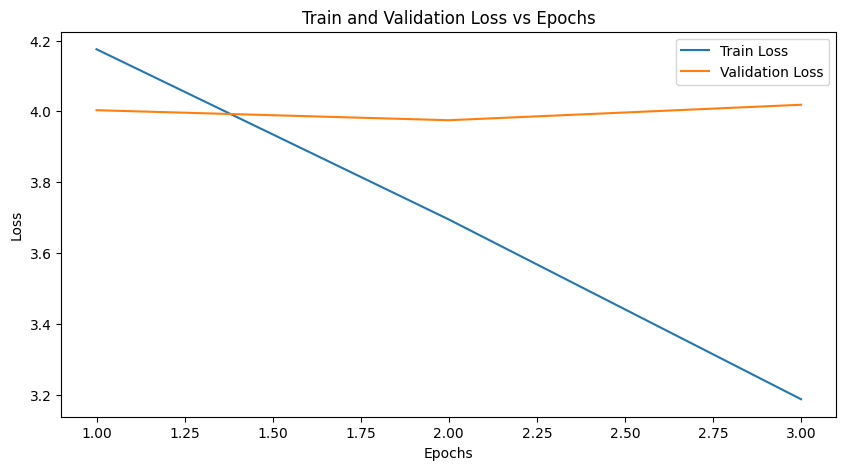

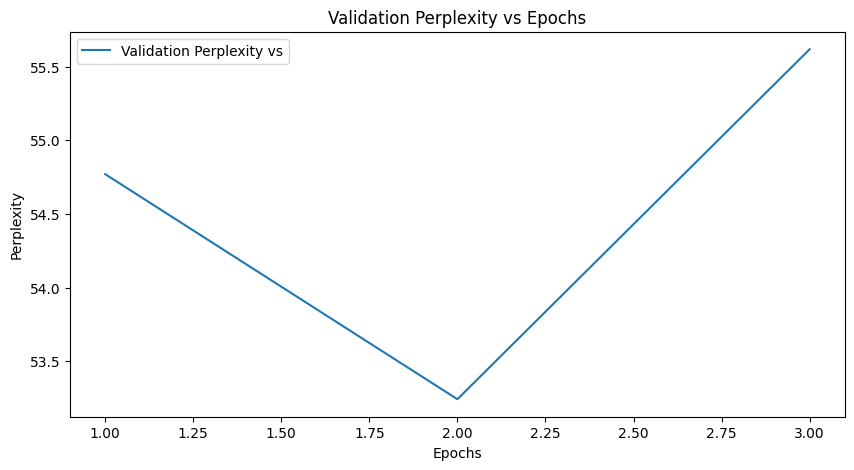

In [18]:
import matplotlib.pyplot as plt
epochs = range(1, num_train_epochs+1)

# Plotting train loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss vs Epochs')
plt.legend()
plt.show()

# Plotting train perplexity
plt.figure(figsize=(10, 5))
plt.plot(epochs, perplexity_list, label='Validation Perplexity vs')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Validation Perplexity vs Epochs')
plt.legend()
plt.show()

# Test the model

In [21]:
test_perplexity = perplexity_score(model, test_dataloader, 'cuda')
print(test_perplexity)

eval: 100%|██████████| 313/313 [02:00<00:00,  2.61it/s]

55.79603710049473


In [3]:
bleu_score = calculate_bleu_score(model, test_dataloader, 'cuda')
print(bleu_score)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserW

In [29]:
generate_story("He was born to be a killer")


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"He was born to be a killer but killer has no victim today they meet <sep> I born 2006 this Monday morning Not first time I met her I left for work day before and she left for Sunday I think her car early and had to be towed by some idiot as she got out of driveway I never really understood why she dressed that way but by all accounts like I already knew she special I think that kind of way that I got through tough time but I don't really think that I thought I knew that much back then Because of men't special I think I don't know what happened for that matter for much of my life but I know I caught what happened and survived Even then I thought that no other woman alive should have gone through this This whole accident I had almost lost my job and only job that could pay me enough to live for three days after that and would probably end my life if I hadn't gone through this What happened though next most important thing that I think about least That I couldn't possibly have possibly s